# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `10`
* Students: `Cionca Alexandre, De Goumoëns Frédéric, Donzier Paul, Fluhr Hugo`
* Dataset: `TMDb dataset (subset of IMDb)`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1158]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [1159]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import pandas as pd
import json

#for testing, to be removed
from mpl_toolkits.mplot3d import Axes3D

import networkx as nx

import pygsp as mdeff


In [1160]:
features = pd.read_csv('../Milestone_1/saved_features_M3.csv')

# Importing our dataset that will be updated as adjacency is updated so that we can use it to answer Question 13 (is our clustering representing
# some feature of the movies?)
json_columns = ['genres','crew','production_companies','production_countries']
for column in json_columns:
     features[column] = features[column].apply(json.loads)
        
        
features['genres_name']=""

for i in range(len(features.title)):
    strs=[]
    for ii in range(len(features.genres[i])):
        strs.append(features.genres[i][ii].get('name'))
    features.at[i,'genres_name']=strs

#list(features) used to determine which columns to drop
features = features.drop(columns='Unnamed: 0')
len(features)

1570

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [1161]:
adjacency = np.load("../Milestone_1/saved_adjacency_M3.npy")

n_nodes =   len(adjacency)
print(n_nodes,'nodes')
#adjacency[adjacency<0.05]=0

#adjacency=np.where(adjacency!=0,1.,0.)

1570 nodes


In [1162]:
# We see from the adjacency matrix that there are some movies that don't have any connections to any other movies,
# these nodes don't present any interest to us so we remove them from both the dataframe and the adjacency matrix
deg=np.sum(adjacency,0)
deg_bin=np.argwhere(deg==0).flatten()

adjacency_red = np.delete(adjacency,deg_bin,0)
adjacency_red = np.delete(adjacency_red,deg_bin,1)

fits_red=features.loc[np.argwhere(deg>0).flatten()]
#fits_red=features.loc[np.argwhere(giant==1).flatten()]

# We need to update n_nodes since we have dropped some movies
n_nodes=len(adjacency_red)
n_nodes
adjacency=adjacency_red
len(adjacency)
len(fits_red)

1570

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

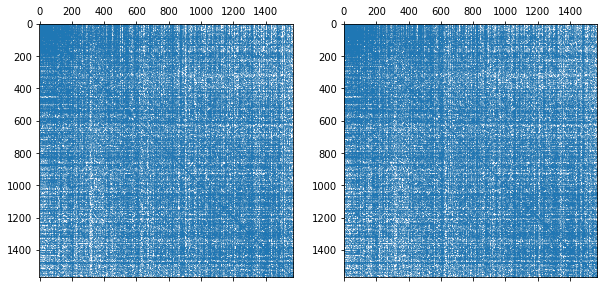

In [1163]:
# We first create the degree vector of our graph :
degrees= np.sum(adjacency,0)

D_sqrt_inv= np.diag(1/np.sqrt(degrees))

laplacian_combinatorial = sparse.csr_matrix(np.diag(degrees)-adjacency)
laplacian_normalized = sparse.csr_matrix(D_sqrt_inv @ laplacian_combinatorial @ D_sqrt_inv)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.spy(laplacian_combinatorial,markersize=0.1)
plt.subplot(122)
plt.spy(laplacian_normalized,markersize=0.1)
lap_un=laplacian_combinatorial.toarray()

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [1164]:
#laplacian =  laplacian_combinatorial
laplacian = laplacian_normalized

# We chose the normalized laplacian because its useful to get the number of clusters (see question 10)

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [1165]:
# Scipy linalg (not scipy.sparse.linagl!!!)
vals_norm,vects_norm = scipy.linalg.eigh(laplacian.toarray())
print(vals_norm[0])

# Numpy linalg
eigenvalues, eigenvectors = np.linalg.eigh(laplacian.toarray())
print(eigenvalues[0])

vals_un,vects_un = np.linalg.eigh(lap_un)

#assert eigenvectors.shape == (n_nodes, n_nodes)

4.440892098500626e-16
1.0221483149716457e-16


In [1166]:
#%timeit vals_norm,vects_norm = scipy.linalg.eigh(laplacian.toarray())

In [1167]:
#%timeit eigenvalues, eigenvectors = np.linalg.eigh(laplacian.toarray())

In [1168]:
#print(eigenvectors[:,0])
#print(vects[:,0])
sum(vects_norm[:,0]**2) #gives the norm of the vector which is equal to 1

1.0000000000000004

Justify your choice of eigensolver.

**Your answer here.**

https://stackoverflow.com/questions/6684238/whats-the-fastest-way-to-find-eigenvalues-vectors-in-python

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

S is the incidence matrix. It contains the information about the orientation of the edges, it gives a correspondace between
vertices and edges. S is of size N x M, N being number of vertices and M number of edges. S(i,j)= +1 / -1 if node i is 
the outgoing / ingoing node of edge j, S(i,j)= 0 othewise.
$S^\top x$ computes the gradient of x. It gives the derivative of x at each edge, $S^\top x$ is a vector of size M.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

Remembering that $L = S S^\top $ and that $\| S^\top u_k \|_2^2 = u_k^\top S S^\top u_k  $. We use the definition of eigenvalues and eigenvectors :

$L u_k = \lambda_k u_k$

Left-multiplying both sides by $u_k^\top$ gives :

$ u_k^\top L u_k = u_k^\top \lambda_k u_k$

$\lambda_k $ being a scalar we can rewrite :

$ u_k^\top L u_k = \lambda_k u_k^\top  u_k$

Assuming that the eigenvectors are normalized (which is the case for most eigensolvers) we get :

$ u_k^\top L u_k = \lambda_k $

Which is equivalent to :

$ \lambda_k = u_k^\top L u_k = u_k^\top S S^\top u_k = \| S^\top u_k \|_2^2 $



What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

This quantity is the square of the norm of the gradient of x, meaning that it tells us how much the signal x varies over the graph.
It is an indicator of the smoothness of x over the graph.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

In [1169]:
vects_norm[:,0] # for normalized, same as combinatorial but normalized by degree? in lecture : L*u = lambda*D*u 
vects_un[:,0]

array([-0.02523772, -0.02523772, -0.02523772, ..., -0.02523772,
       -0.02523772, -0.02523772])

**Your annswer here.**

Should be indicating vector of giant component, so full of 1's (normalized) for our network which is connected

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

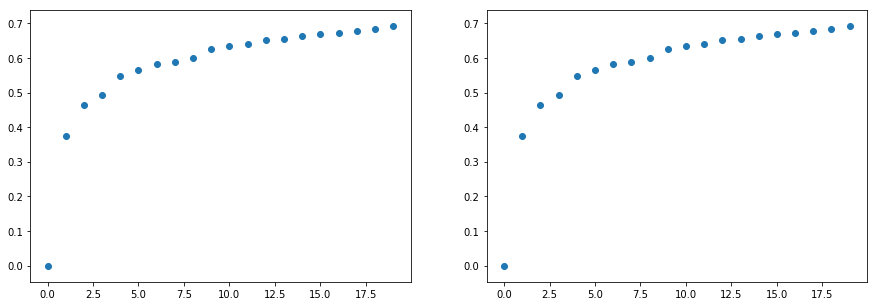

In [1170]:
eig_min=0
eig_max=20
x = range(eig_min,eig_max,1)

plt.figure(figsize=(15,5))


plt.subplot(121)
#plt.plot(vals)
plt.scatter(x,vals_norm[eig_min:eig_max])
#plt.scatter(vals[:exe],list(np.ones((exe,1))))

plt.subplot(122)
#plt.plot(eigenvalues)
plt.scatter(x,eigenvalues[eig_min:eig_max])
#plt.scatter(eigenvalues[:exe],list(np.ones((exe,1))))

**Your answer here.**

How many connected components are there in your graph? Answer using the eigenvalues only.

In [1171]:
# Your code here.
# 1 since first eigenvalue is zero

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

In [1172]:
idx=np.where(np.abs(vects_un[:,3]) <1e-8 , 0, 1)
# create an array containing the index of the nodes which are not in the giant component
idx_non_giant=np.argwhere(1-idx > 0)
print(len(np.argwhere(idx > 0)))
print(len(idx_non_giant))


adjacency_red = np.delete(adjacency,idx_non_giant,0)
adjacency_red = np.delete(adjacency_red,idx_non_giant,1)
feat=fits_red
feat=fits_red.loc[np.argwhere(idx > 0).flatten()]
print(len(feat))
print(len(adjacency_red))

1570
0
1570
1570


In [1173]:
Graph = nx.from_numpy_array(adjacency)
Gr_2 = nx.from_numpy_array(adjacency_red)

giant=max(nx.connected_component_subgraphs(Graph), key=len)
print(nx.is_connected(Graph))
print(nx.is_connected(Gr_2))



adjacency_gc=np.asarray(nx.to_numpy_matrix(giant))
print(len(adjacency_gc))
print(np.max(adjacency_red-adjacency_gc))

#nx.write_gexf(Gr_2, 'movies_keywords.gexf')

##print(nx.connected_components(Graph))
len(adjacency_gc)

True
True
1570
0.0


1570

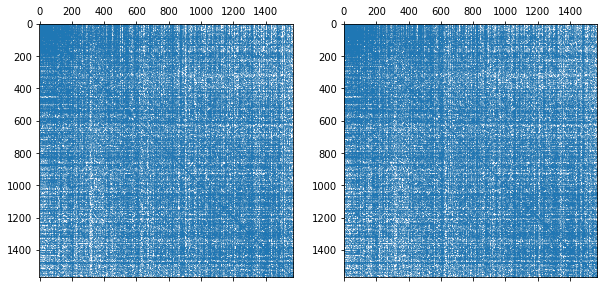

In [1174]:
degrees=np.sum(adjacency_red,0)
D_sqrt_inv= np.diag(1/np.sqrt(degrees))

laplacian_combinatorial = sparse.csr_matrix(np.diag(degrees)-adjacency_red)
laplacian_normalized = sparse.csr_matrix(D_sqrt_inv @ laplacian_combinatorial @ D_sqrt_inv)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.spy(laplacian_combinatorial,markersize=0.1)
plt.subplot(122)
plt.spy(laplacian_normalized,markersize=0.1)
laplacian=laplacian_normalized

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

Embed in an Euclidian Space, for visualisation for example, the visualisation has to "show" properties of the graph
Laplacian Eigenmaps are also useful for dimensionality reduction using neighborhood information of the dataset (each data point is a node of the graph)

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [1175]:
# We first create the degree vector of our graph :
degrees=np.sum(adjacency_gc,0)
D_sqrt_inv= np.diag(1/np.sqrt(degrees))

laplacian_combinatorial = sparse.csr_matrix(np.diag(degrees)-adjacency_gc)
laplacian_normalized = sparse.csr_matrix(D_sqrt_inv @ laplacian_combinatorial @ D_sqrt_inv)

In [1286]:
lapi=laplacian_combinatorial.toarray()



#print(np.all(np.linalg.eigvals(laplacian_combinatorial.toarray()) > 0))
#print(np.all(np.linalg.eigvals(laplacian_normalized.todense()) > 0))

print(laplacian_normalized.todense())

<class 'numpy.ndarray'>
False
False
[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.          0.
  -0.01807754]
 [ 0.          0.          0.         ...  0.          1.
  -0.00939806]
 [ 0.          0.          0.         ... -0.01807754 -0.00939806
   1.        ]]


In [1283]:
feat.to_csv('../saved_features_M3.csv', encoding='utf-8')
np.save('../saved_laplacian_M3.npy',laplacian_normalized.toarray())

n_eig=100

# Eigenvalues and eigenvectors are computed using the 
vals_s, eigenvectors_s = sparse.linalg.eigsh(laplacian_normalized,n_eig,maxiter=400000, which='SM')

# Eigenvectors matrix is Re-normalized by the degrees
eigenV = D_sqrt_inv @ eigenvectors_s

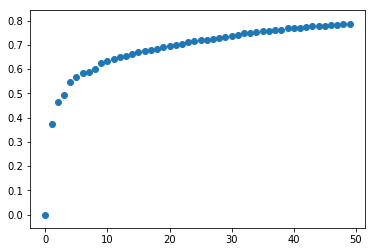

In [1177]:
n_min=0
n_max=50
ran=range(len(vals_s))
plt.scatter(ran[n_min:n_max],vals_s[n_min:n_max])

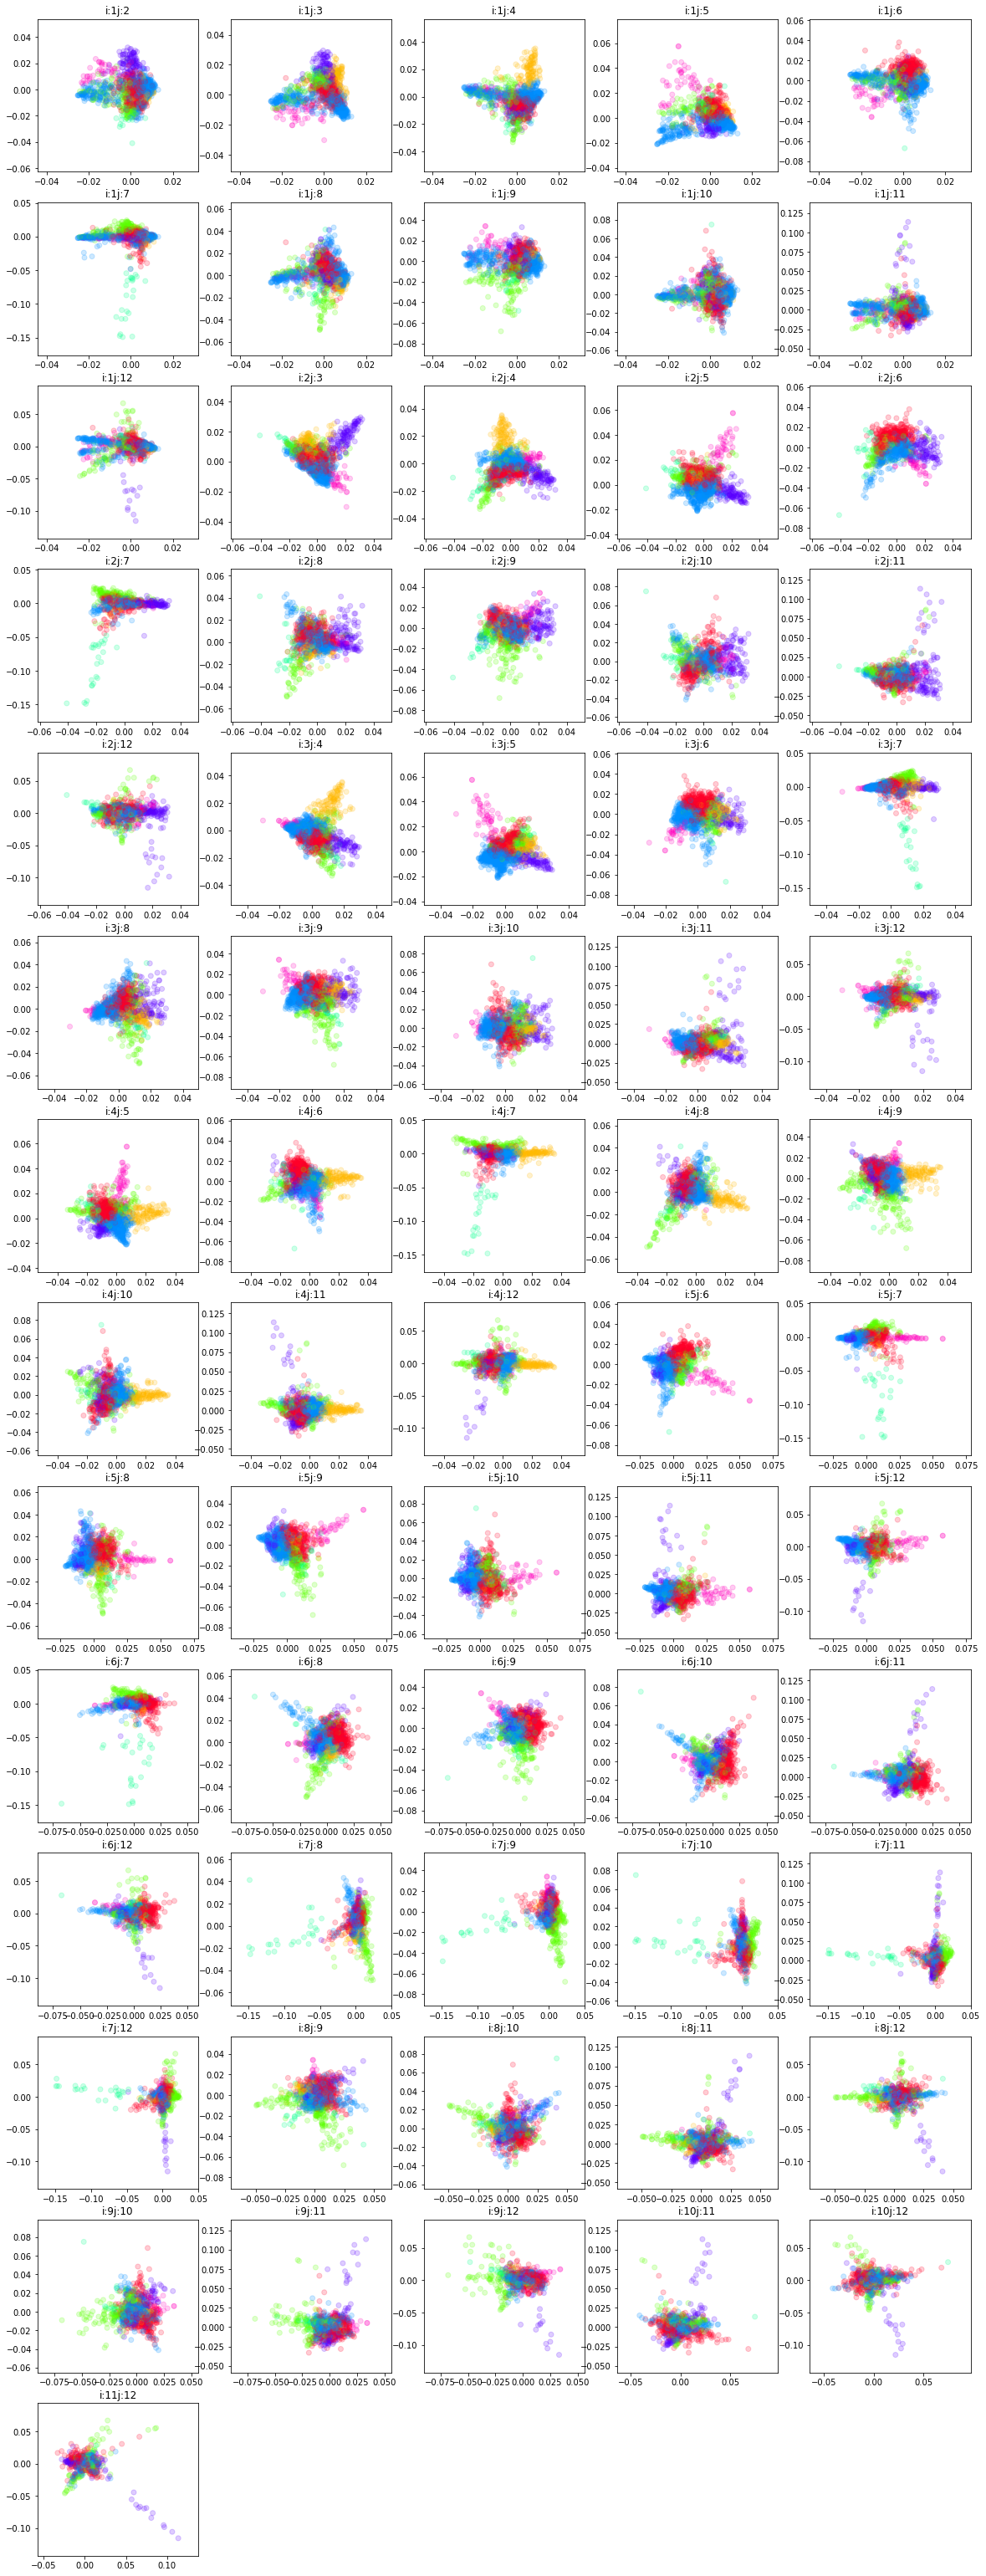

In [1247]:
k=1
eig_max=13

plt.figure(figsize=(20,80))

for i in range(1, eig_max,1):
    for j in range(i+1,eig_max,1):
        #x=eigenvectors_s[:,i]
        #y=eigenvectors_s[:,j]
        x=eigenV[:,i]
        y=eigenV[:,j]
        plt.subplot(20,5,k)
        strange='i:'+ str(i) +'j:'+ str(j)
        plt.title(strange)
        plt.scatter(x, y, alpha=0.2, c=K_means.labels_, cmap='gist_rainbow')
        k+=1
        


Plot the nodes embedded in 2D. Comment on what you see.

Text(0, 0.5, '9th Eigenvector')

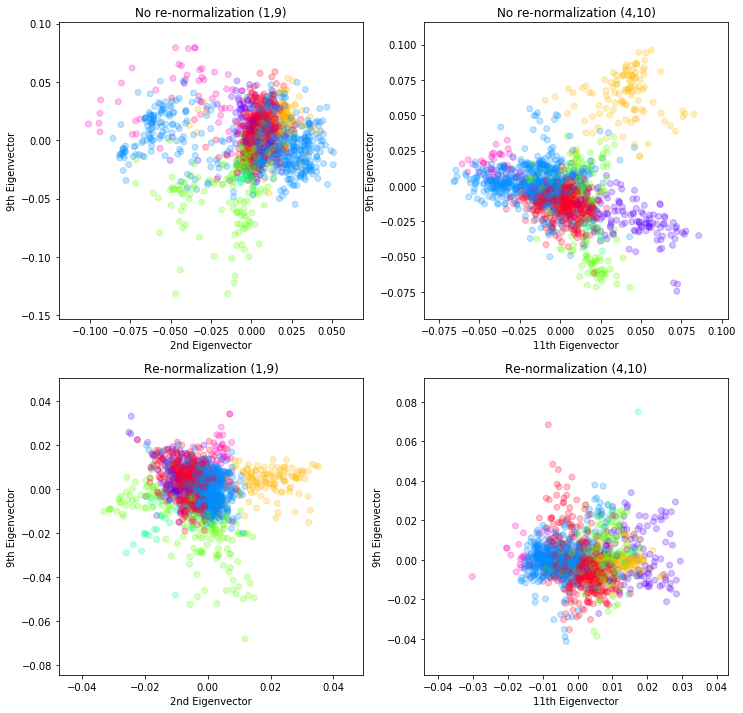

In [1253]:
plt.figure(figsize=(12,12))

x1= eigenvectors_s[:,1]
y1= eigenvectors_s[:,9]
x2= eigenvectors_s[:,3]
y2= eigenvectors_s[:,4]

plt.subplot(2,2,1)
plt.scatter(x1, y1, alpha=0.25, c=K_means.labels_, cmap='gist_rainbow');
plt.title("No re-normalization (1,9)")
plt.xlabel("2nd Eigenvector")
plt.ylabel("9th Eigenvector")

plt.subplot(2,2,2)
plt.scatter(x2, y2, alpha=0.25, c=K_means.labels_, cmap='gist_rainbow');
plt.title("No re-normalization (4,10)")
plt.xlabel("11th Eigenvector")
plt.ylabel("9th Eigenvector")

x1= eigenV[:,4]
y1= eigenV[:,9]
x2= eigenV[:,3]
y2= eigenV[:,10]

plt.subplot(2,2,3)
plt.scatter(x1, y1, alpha=0.25, c=K_means.labels_, cmap='gist_rainbow');
plt.title("Re-normalization (1,9)")
plt.xlabel("2nd Eigenvector")
plt.ylabel("9th Eigenvector")

plt.subplot(2,2,4)
plt.scatter(x2, y2, alpha=0.25, c=K_means.labels_, cmap='gist_rainbow');
plt.title("Re-normalization (4,10)")
plt.xlabel("11th Eigenvector")
plt.ylabel("9th Eigenvector")

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

LES DISTANCES

A COMPLETER <br>
Points close to each other on the manifold are mapped close to each other in the low-dimensional space, preserving local distances.
https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Laplacian_eigenmaps

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

We choose k from observing the spectrum of our graph. As we saw in the lecture, the index of the eigenvalue (of the normalized Laplacian) at which there is a gap (a discontinuity in the spectrum) is a good choice for the number of clusters.

In [1243]:
n_eigV=12
# 3 5 10
k=8
min_max_val=5000

H=eigenvectors_s[:,1:n_eigV]

for n_eigV in range(k,20,1):

    H=eigenV[:,1:n_eigV]

    K_means=KMeans(n_clusters = k, random_state=0).fit(H)
    labs=[]

    for i in range(k):
        labs.append(len(np.argwhere(K_means.labels_ == i)))
        #print(i,':',labs[i])
    print('n_eig',n_eigV,labs)

n_eig 8 [55, 25, 453, 125, 169, 142, 385, 216]
n_eig 9 [558, 61, 26, 459, 54, 123, 120, 169]
n_eig 10 [372, 187, 120, 67, 116, 25, 56, 627]
n_eig 11 [359, 534, 212, 63, 56, 127, 194, 25]
n_eig 12 [57, 533, 704, 43, 71, 119, 25, 18]
n_eig 13 [198, 1041, 123, 25, 57, 13, 71, 42]
n_eig 14 [148, 672, 13, 173, 26, 393, 80, 65]
n_eig 15 [130, 191, 8, 26, 171, 13, 964, 67]
n_eig 16 [81, 516, 13, 714, 140, 72, 26, 8]
n_eig 17 [80, 376, 24, 879, 120, 7, 13, 71]
n_eig 18 [42, 177, 75, 23, 13, 1043, 7, 190]
n_eig 19 [333, 13, 937, 5, 25, 161, 47, 49]


In [1244]:
k=7
n_eigV=10
# 10 12

H=eigenV[:,1:n_eigV]

K_means=KMeans(n_clusters = k, random_state=0).fit(H)
labs=[]

for i in range(k):
    labs.append(len(np.argwhere(K_means.labels_ == i)))
    print(i,':',labs[i])

labels=K_means.labels_
## turn a graph into a set of vectors and run k-means on it,
## rows are samples, columns are features

0 : 500
1 : 116
2 : 177
3 : 25
4 : 576
5 : 120
6 : 56


In [1033]:
print(K_means.labels_)
print(K_means.labels_+1)

[3 2 0 ... 1 1 1]
[4 3 1 ... 2 2 2]


### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

1570
1570


Text(0.5, 1.05, 'adjacency matrix')

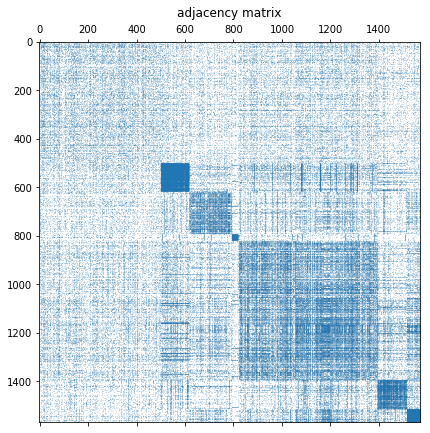

In [1245]:
# Your code here.
## order by clusters, the order is no longer arbitrary, comment on wether this shows a structure in the network
## maybe the clusters will give sequels? MCU, Pirates of the carribeans...
## the clusters number order doesn't matter
sort_by_cluster=np.argsort(labels)
print(len(labels))
print(len(fits_red))
feat['cluster'] = labels
feat['index_by_cluster']=np.argsort(sort_by_cluster)
feat.sort_values('index_by_cluster')

adjacency_sorted=adjacency_red[sort_by_cluster,:]
adjacency_sorted=adjacency_sorted[:,sort_by_cluster]

plt.figure(figsize=(7,7))
plt.spy(adjacency_sorted, markersize=0.05)
#plt.imshow(adjacency_sorted)
#plt.colorbar()
#plt.show()
plt.title('adjacency matrix')

In [1000]:
feat.sort_values('cluster')

,Unnamed: 0.1,movie_id,title,cast,crew,budget,genres,keywords,original_language,popularity,...,release_date,revenue,runtime,vote_average,vote_count,keywords_key,keywords_names,genres_name,cluster,index_by_cluster
154,154,87827,Life of Pi,"[{'cast_id': 15, 'character': 'Pi Patel (16 / ...","[{'credit_id': '52fe49db9251416c910bb0ab', 'de...",120000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...","[{'id': 270, 'name': 'ocean'}, {'id': 2580, 'n...",en,51.328145,...,2012-11-20,609016565,127.0,7.2,5797,"[270, 2580, 4096, 4809, 6150, 12971, 18068, 15...","['ocean', 'shipwreck', 'hindu', 'tiger', 'fait...","[Adventure, Drama, Action]",0,0
751,752,2054,Mr. Holland's Opus,"[{'cast_id': 10, 'character': 'Glenn Holland',...","[{'credit_id': '56488f159251413acf00765f', 'de...",0,"[{'id': 10402, 'name': 'Music'}, {'id': 18, 'n...","[{'id': 1233, 'name': 'composer'}, {'id': 1310...",en,6.775294,...,1995-12-29,106269971,137.0,6.9,113,"[1233, 1310, 1635, 4344, 4488, 5289, 6027, 158...","['composer', 'mentor', 'deaf-mute', 'musical',...","[Music, Drama, Family]",0,1
403,403,100241,"I, Frankenstein","[{'cast_id': 1, 'character': 'Adam', 'credit_i...","[{'credit_id': '52fe49d0c3a36847f81a7b85', 'de...",65000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...","[{'id': 634, 'name': 'soul'}, {'id': 2011, 'na...",en,31.324734,...,2014-01-22,71154592,92.0,5.0,687,"[634, 2011, 2095, 2486, 3071, 6152, 6737, 1084...","['soul', 'queen', 'anti hero', 'fantasy', 'pri...","[Horror, Thriller]",0,2
1252,1254,101173,Coriolanus,"[{'cast_id': 3, 'character': 'Tullus Aufidius'...","[{'credit_id': '52fe49e9c3a36847f81ad035', 'de...",7700000,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...","[{'id': 1399, 'name': 'senate'}, {'id': 1402, ...",en,7.554799,...,2011-02-14,1072602,123.0,5.9,131,"[1399, 1402, 5563, 9823, 10614, 14708, 14767, ...","['senate', 'general', 'market', 'rivalry', 'tr...","[Drama, Thriller]",0,3
757,758,6488,Arachnophobia,"[{'cast_id': 1, 'character': 'Dr. Ross Jenning...","[{'credit_id': '52fe4455c3a36847f808fe5f', 'de...",31000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...","[{'id': 1415, 'name': 'small town'}, {'id': 97...",en,15.895661,...,1990-08-09,53208180,103.0,6.2,433,"[1415, 9744, 158120, 158124, 158126, 158129, 1...","['small town', 'outbreak', 'exterminator', 'sp...","[Comedy, Horror]",0,4
169,169,254128,San Andreas,"[{'cast_id': 2, 'character': 'Ray Gaines', 'cr...","[{'credit_id': '55dd12ca9251417444000ce5', 'de...",110000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...","[{'id': 387, 'name': 'california'}, {'id': 352...",en,100.412364,...,2015-05-27,470490832,114.0,6.0,2968,"[387, 3521, 188351, 189411, 209714, 213895, 21...","['california', 'earthquake', 'catastrophe', 'd...","[Action, Drama, Thriller]",0,5
766,767,2907,The Addams Family,"[{'cast_id': 3, 'character': 'Gomez Addams', '...","[{'credit_id': '52fe4374c3a36847f80554dd', 'de...",30000000,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...","[{'id': 2643, 'name': 'dead wish'}, {'id': 313...",en,37.179547,...,1991-11-22,191502426,99.0,6.7,848,"[2643, 3133, 4553, 6464, 10483, 12564, 162810,...","['dead wish', 'vampire', 'black humor', 'uncle...","[Horror, Comedy, Fantasy]",0,6
1219,1221,766,Army of Darkness,"[{'cast_id': 18, 'character': 'Ash', 'credit_i...","[{'credit_id': '52fe4273c3a36847f801f989', 'de...",11000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 27, 'na...","[{'id': 530, 'name': 'prophecy'}, {'id': 616, ...",en,33.758281,...,1992-10-09,0,81.0,7.3,838,"[530, 616, 1400, 1545, 3098, 3970, 4013, 4060,...","['prophecy', 'witch', 'swordplay', 'supermarke...","[Fantasy, Horror, Comedy]",0,7
1216,1218,3175,Barry Lyndon,"[{'cast_id': 9, 'character': 'Barry Lyndon', '...","[{'credit_id': '52fe438dc3a36847f805cca9', 'de...",11000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","[{'id': 3998, 'name': 'palace'}, {'id': 4100, ...",en,29.543331,...,1975-12-18,20000000,184.0,7.7,505,"[3998, 4100, 5330, 6917, 11061, 14985, 157788,...","['palace',

In [1222]:
feat[feat.cluster == 3]

,Unnamed: 0.1,movie_id,title,cast,crew,budget,genres,keywords,original_language,popularity,...,release_date,revenue,runtime,vote_average,vote_count,keywords_key,keywords_names,genres_name,cluster,index_by_cluster
0,0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,150.437577,...,2009-12-10,2787965087,162.0,7.2,11800,"[1463, 2964, 3386, 3388, 3679, 3801, 9685, 984...","['culture clash', 'future', 'space war', 'spac...","[Action, Adventure, Fantasy, Science Fiction]",3,592
32,32,20526,TRON: Legacy,"[{'cast_id': 44, 'character': 'Sam Flynn', 'cr...","[{'credit_id': '52fe43eac3a368484e005c9f', 'de...",170000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'id': 310, 'name': 'artificial intelligence'...",en,73.795050,...,2010-12-10,400062763,125.0,6.3,2841,"[310, 1308, 4286, 4565, 6104, 9758, 12965, 147...","['artificial intelligence', 'secret identity',...","[Adventure, Action, Science Fiction]",3,632
35,35,534,Terminator Salvation,"[{'cast_id': 18, 'character': 'John Connor', '...","[{'credit_id': '52fe424ec3a36847f8013ffd', 'de...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...","[{'id': 83, 'name': 'saving the world'}, {'id'...",en,71.862892,...,2009-05-20,371353001,115.0,5.9,2463,"[83, 310, 530, 582, 679, 1373, 1420, 4458, 456...","['saving the world', 'artificial intelligence'...","[Action, Science Fiction, Thriller]",3,609
37,37,54138,Star Trek Into Darkness,"[{'cast_id': 2, 'character': 'James T. Kirk', ...","[{'credit_id': '52fe488dc3a36847f816d839', 'de...",190000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1612, 'name': 'spacecraft'}, {'id': 60...",en,78.291018,...,2013-05-05,467365246,132.0,7.4,4418,"[1612, 6054, 9663, 9685, 9882, 9951, 156395, 1...","['spacecraft', 'friendship', 'sequel', 'futuri...","[Action, Adventure, Science Fiction]",3,607
51,51,137113,Edge of Tomorrow,"[{'cast_id': 12, 'character': 'Maj. William ""B...","[{'credit_id': '54124fadc3a3682f6b0004d7', 'de...",178000000,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...","[{'id': 563, 'name': 'deja vu'}, {'id': 1521, ...",en,79.456485,...,2014-05-27,370541256,113.0,7.6,4858,"[563, 1521, 2062, 4565, 6091, 9951, 11109, 130...","['deja vu', 'time warp', 'restart', 'dystopia'...","[Action, Science Fiction]",3,601
57,57,119450,Dawn of the Planet of the Apes,"[{'cast_id': 8, 'character': 'Caesar', 'credit...","[{'credit_id': '54c4d125c3a36814210139a5', 'de...",170000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...","[{'id': 3077, 'name': 'leader'}, {'id': 4090, ...",en,243.791743,...,2014-06-26,710644566,130.0,7.3,4410,"[3077, 4090, 4458, 4565, 5774, 9663, 9720, 147...","['leader', 'colony', 'post-apocalyptic', 'dyst...","[Science Fiction, Action, Drama, Thriller]",3,621
64,64,296,Terminator 3: Rise of the Machines,"[{'cast_id': 6, 'character': 'The Terminator',...","[{'credit_id': '52fe4234c3a36847f800bcef', 'de...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...","[{'id': 83, 'name': 'saving the world'}, {'id'...",en,69.405188,...,2003-07-02,435000000,109.0,5.9,2143,"[83, 310, 312, 679, 1373, 1381, 2650, 2651, 27...","['saving the world', 'artificial intelligence'...","[Action, Thriller, Science Fiction]",3,634
66,66,157336,Interstellar,"[{'cast_id': 9, 'character': 'Joseph Cooper', ...","[{'credit_id': '52fe4bbf9251416c910e4801', 'de...",165000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...","[{'id': 83, 'name': 'saving the world'}, {'id'...",en,724.247784,...,2014-11-05,675120017,169.0,8.1,10867,"[83, 310, 494, 641, 1432, 1963, 3417, 3801, 43...","['saving the world', 'artificial intelligence'...","[Adventure, Drama, Science Fiction]",3,622
76,76,87101,Terminator Genisys,"[{'cast_id': 1, 'character': 'The Terminator',...","[{'credit_id': '5605f91d925141306000071e', 'de...",155000000,"[{'id': 878, 'name'

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**